In [2]:
# imports
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
import pulp
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA

In [3]:
# Load the breast cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [5]:
from sklearn.cluster import KMeans

# Number of clusters (assuming 2 for breast cancer classification: benign and malignant)
k = 2

# Apply k-means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(X_scaled)
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_

In [7]:

# Define the MIP model
model = pulp.LpProblem("Breast_Cancer_Classification", pulp.LpMinimize)

# Number of data points and features
m, n = X_scaled.shape

# Variables
alpha = pulp.LpVariable.dicts("alpha", range(m), lowBound=0)
y_il = pulp.LpVariable.dicts("y_il", [(i, l) for i in range(m) for l in range(k)], cat='Binary')
z_il = pulp.LpVariable.dicts("z_il", [(i, l, j) for i in range(m) for l in range(k) for j in range(n)], lowBound=0)

# Objective function
model += pulp.lpSum(alpha[i] for i in range(m))

# Constraints
M = 1e6  # Large number for the big-M method

for i in range(m):
    for l in range(k):
        model += alpha[i] >= pulp.lpSum(z_il[(i, l, j)] for j in range(n))
        model += alpha[i] <= pulp.lpSum(z_il[(i, l, j)] for j in range(n)) + M * (1 - y_il[(i, l)])
        for j in range(n):
            model += z_il[(i, l, j)] >= X_scaled[i, j] - cluster_centers[l, j]
            model += z_il[(i, l, j)] >= -(X_scaled[i, j] - cluster_centers[l, j])

for i in range(m):
    model += pulp.lpSum(y_il[(i, l)] for l in range(k)) == 1

# Solve the MIP model
model.solve()

# Extract classification results
classification_results = [pulp.value(y_il[(i, l)]) for i in range(m) for l in range(k)]
classification = np.array(classification_results).reshape(m, k).argmax(axis=1)



Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /usr/local/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/q9/clg4hjcx3wgcds_vy_cwqc0m0000gn/T/6e730b53963a429d994c3d51aaff895f-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/q9/clg4hjcx3wgcds_vy_cwqc0m0000gn/T/6e730b53963a429d994c3d51aaff895f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 71130 COLUMNS
At line 215088 RHS
At line 286214 BOUNDS
At line 287353 ENDATA
Problem MODEL has 71125 rows, 35847 columns and 141112 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 21142.1 - 0.40 seconds
Cgl0004I processed model has 2276 rows, 35278 columns (569 integer (569 of which binary)) and 71694 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 21142.1
Cbc0038I Relaxing continuous gives 21142.1
Cbc0038

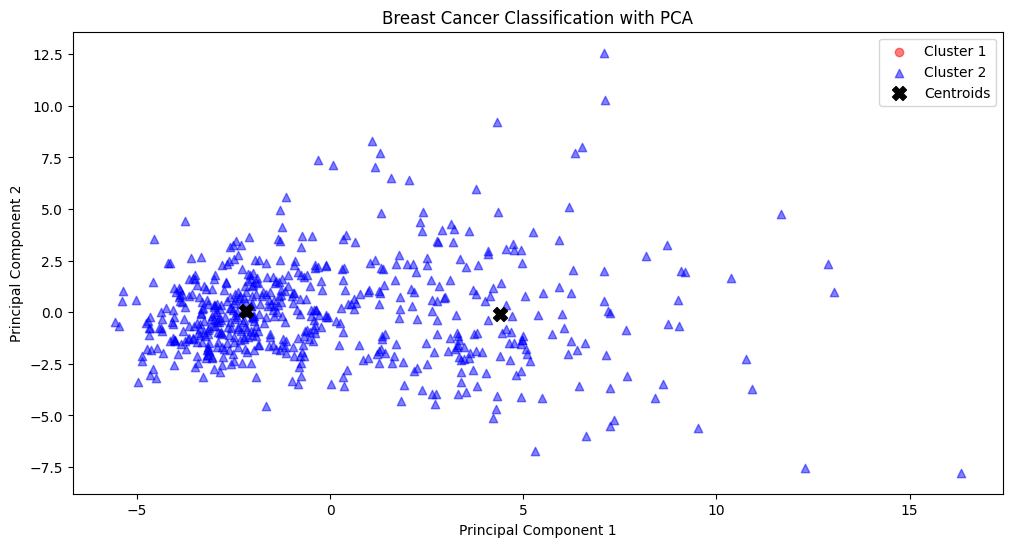

In [8]:
# Plot the PCA results
plt.figure(figsize=(12, 6))

# Scatter plot of the first two principal components
for i, color, marker in zip(range(k), ['red', 'blue'], ['o', '^']):
    plt.scatter(X_pca[classification == i, 0], X_pca[classification == i, 1], 
                color=color, marker=marker, label=f'Cluster {i + 1}', alpha=0.5)

# Plot the cluster centers
centers_pca = pca.transform(cluster_centers)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], color='black', marker='X', s=100, label='Centroids')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Breast Cancer Classification with PCA')
plt.legend()
plt.show()